Using risk label column: LABEL2
Risk categories in NY today: ['General Thunderstorms Risk' 'Marginal Risk']


/tmp/ipykernel_1644299/1001363746.py:79: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Risk Level")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


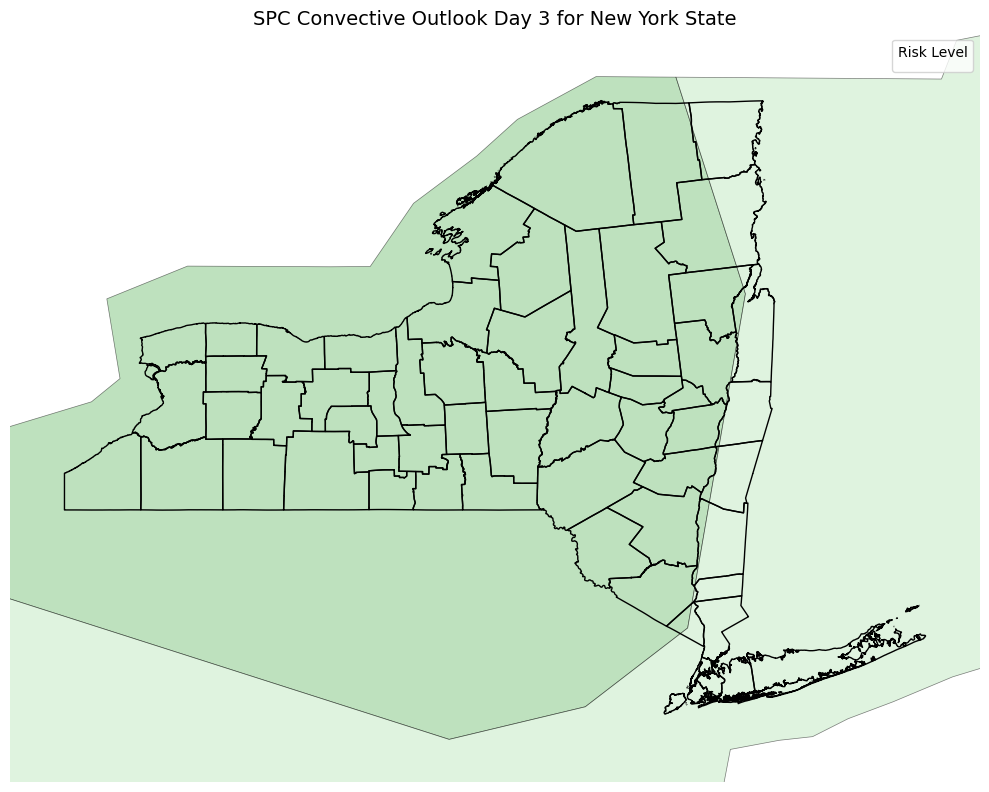

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import os

shapefile_path = "/nfs/home11/ugrad/2024/es348865/Current_Code_projects/swrcc_code/shapefiles_code/state/NYS_Counties.shp"

# Load NY counties shapefile
ny_counties = gpd.read_file("/nfs/home11/ugrad/2024/es348865/Current_Code_projects/swrcc_code/shapefiles_code/state/NYS_Counties.shp")

# Merge all county geometries into one unified NY state shape
ny_union = ny_counties.union_all()

# Download today's SPC Day 3 outlook shapefile
day3_url = "https://www.spc.noaa.gov/products/outlook/day3otlk-shp.zip"
r = requests.get(day3_url)

if r.status_code != 200:
    print("Failed to download shapefile.")
    exit()

# Extract the shapefile contents
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall("day3_outlook")

# Read the shapefile
outlook_gdf = gpd.read_file("day3_outlook/day3otlk_cat.shp")

# Reproject to match NY shapefile if needed
if outlook_gdf.crs != ny_counties.crs:
    outlook_gdf = outlook_gdf.to_crs(ny_counties.crs)

# Subset to areas overlapping New York
outlook_ny = outlook_gdf[outlook_gdf.geometry.intersects(ny_union)].copy()

# Automatically detect correct risk label column
risk_col = None
for col in outlook_ny.columns:
    if outlook_ny[col].dtype == object and outlook_ny[col].str.contains("Risk", case=False, na=False).any():
        risk_col = col
        break

if risk_col is None:
    raise ValueError("Could not find a valid risk label column in the GeoDataFrame.")

print(f"Using risk label column: {risk_col}")
print("Risk categories in NY today:", outlook_ny[risk_col].unique())

# Risk level to color mapping (adjust as needed)
risk_colors = {
    "Marginal Risk": "#7fc57f",
    "Slight Risk": "#f6f67f",
    "Enhanced Risk": "#e6c27f",
    "Moderate Risk": "#e67f7f",
    "High Risk": "#ff7fff",
    "General Thunderstorms Risk": "#c0e8c0",
}

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NY counties
ny_counties.boundary.plot(ax=ax, color="black", linewidth=1)

# Plot SPC outlooks by risk category
for label, color in risk_colors.items():
    subset = outlook_ny[outlook_ny[risk_col] == label]
    if not subset.empty:
        subset.plot(ax=ax, color=color, label=label, alpha=0.5, edgecolor='k', linewidth=0.5)

# Set the map extent to NY bounds
minx, miny, maxx, maxy = ny_union.bounds
ax.set_xlim(minx - 0.5, maxx + 0.5)
ax.set_ylim(miny - 0.5, maxy + 0.5)

ax.set_title("SPC Convective Outlook Day 3 for New York State", fontsize=14)
ax.legend(title="Risk Level")
ax.axis("off")

plt.tight_layout()
plt.show()
# Final
